**Indexing all the images and saving it to a new field in the existing Elasticsearch index**

In [30]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io

# Load data
pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')
columns = ['title', 'caption', 'imgPath']

pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)
combined_df.insert(0, 'id', combined_df.reset_index().index + 1)
#sample_df = combined_df.head(100)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
logit_scale = model.logit_scale.exp().item()  # Get the exponential of the logit scale for scaling the cosine similarity

# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "documents"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "image_embedding": {"type": "dense_vector", "dims": 768}
            }
        }
    })
# The document already exist, with the new field name 'clip_embedding'

# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        return base64.b64encode(img_bytes).decode("utf-8")

# Function to generate and normalize image embedding
def generate_image_embedding(image):
    #image = image.convert("RGB")  # Ensure image is in RGB
    inputs = processor(images=[image], return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.get_image_features(**inputs).squeeze(0)
        normalized_output = (output / output.norm(p=2, dim=-1, keepdim=True))
        return normalized_output.cpu().numpy().tolist()  # Move back to CPU for Elasticsearch indexing

# Indexing only images
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    image_path = row['imgPath']
    image = Image.open(image_path)
    img_emb = generate_image_embedding(image)
    
    # Combine title and caption to form a text used for hashing
    combined_text = f"{row['title']}. {row['caption']}"
    #combined_text = row['title'] + row['caption']
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Update the document in Elasticsearch with the new clip_embedding
    es.update(index=index_name, id=unique_id, body={
        "doc": {
            "clip_embedding": img_emb
        }
    })

Using device: cuda


100%|██████████| 29354/29354 [35:36<00:00, 13.74it/s] 


Top 3 relevant documents based on text query:
1. Title: Overview of the U S. Hispanic Population  
 Content: Latinos of Mexican origin are by far the largest national origin group, representing about 60 percent of the Hispanic population. Puerto Ricans are the next largest and they are far behind, making up just 10 percent of all Latinos. The rest of the Hispanic population is divided among persons who trace their roots to many different nations. 
 Score: 34.995018


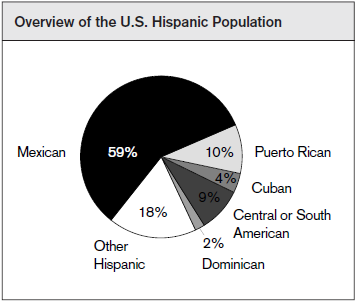

2. Title: U.S. Hispanic Population in 2012 
 Content: The Hispanic population grew to 53 million in 2012, a 50% increase since 2000 and nearly six times the population in 1970, according to the most recent U.S. Census Bureau data. Meanwhile, the overall U.S. population increased by only 12% from 2000 to 2012. Hispanic population growth accounted for more than half of the country’s growth in this time period.
Much of the growth is occurring in a relatively small geographic area. A Pew Research Center analysis last year found that the 10 largest counties by Hispanic population accounted for 22% of the national Hispanic population growth between 2000 and 2011. Half of these counties are located in California. 
 Score: 32.168358


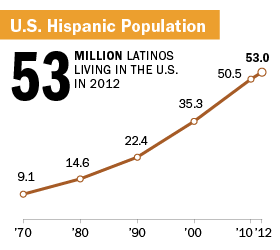

3. Title: Figure 1 U.S. Hispanic Population, by Origin, 2010 (in thousands) 
 Content: Among the 50.7 million Hispanics in the United States, nearly two-thirds (65%), or 33 million, self-identify as being of Mexican origin, according to tabulations of the 2010 American Community Survey (ACS) by the Pew Hispanic Center, a project of the Pew Research Center. No other Hispanic subgroup rivals the size of the Mexican-origin population. Puerto Ricans, the nation’s second largest Hispanic origin group, make up just 9% of the total Hispanic population in the 50 states and the District of Columbia. 
 Score: 31.266613


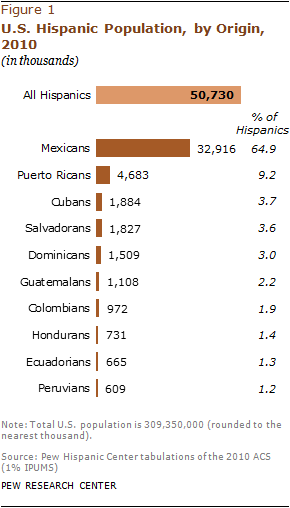

In [31]:
# Text query example and fetching images based on text query
text_query = "What is the Hispanic population in the United States?"
inputs = processor(text=[text_query], padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(**inputs).squeeze(0)
    text_features = (text_features / text_features.norm(p=2, dim=-1, keepdim=True)).cpu().numpy().tolist() # Move back to CPU for Elasticsearch

# Elasticsearch query to find relevant images
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'clip_embedding') * params.logit_scale + 1.0",
            "params": {
                "query_vector": text_features,
                "logit_scale": logit_scale
            }
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on text query:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()

**Indexing all the images and text together, and saving it to a new field in the existing Elasticsearch index** 

*Retrival using random image, and manually added text query*

In [28]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io

# Load data
pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')
columns = ['title', 'caption', 'imgPath']

pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)
combined_df.insert(0, 'id', combined_df.reset_index().index + 1)
#sample_df = combined_df.head(100)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
logit_scale = model.logit_scale.exp().item()  # Get the exponential of the logit scale for scaling the cosine similarity

# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "documents"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "image_embedding": {"type": "dense_vector", "dims": 768}
            }
        }
    })
# The document already exist, with the new field name 'clip_embedding'

# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        return base64.b64encode(img_bytes).decode("utf-8")

# Function to generate, combined, normalize image and text embedding
def generate_embedding(image, text):
    #image = image.convert("RGB")  # Ensure image is in RGB
    img_inputs = processor(images=[image], return_tensors="pt").to(device)
    txt_inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**img_inputs).squeeze(0)
        text_features = model.get_text_features(**txt_inputs).squeeze(0)
        combined_features = torch.cat([image_features, text_features], dim=-1)
        normalized_features = (combined_features / combined_features.norm(p=2, dim=-1, keepdim=True))
        return normalized_features.cpu().numpy().tolist()  # Move back to CPU for Elasticsearch indexing

# Indexing only images
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    # Combine title and caption to form a text used for embedding and hashing
    combined_text = f"{row['title']}. {row['caption']}"
    
    image_path = row['imgPath']
    image = Image.open(image_path)
    imgtext_emb = generate_embedding(image,combined_text)
    
    #combined_hash = row['title'] + row['caption']
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Update the document in Elasticsearch with the new clip_embedding
    es.update(index=index_name, id=unique_id, body={
        "doc": {
            "imgtext_embedding": imgtext_emb
        }
    })

Using device: cuda


100%|██████████| 29354/29354 [45:43<00:00, 10.70it/s] 


In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io

# Load data
pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')
columns = ['title', 'caption', 'imgPath']

pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)
combined_df.insert(0, 'id', combined_df.reset_index().index + 1)
#sample_df = combined_df.head(100)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
logit_scale = model.logit_scale.exp().item()  # Get the exponential of the logit scale for scaling the cosine similarity
# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "documents"

/home/mleshashi/thesis-sharma/sraEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        return base64.b64encode(img_bytes).decode("utf-8")

# Function to generate, combined, normalize image and text embedding
def generate_embedding(image, text):
    #image = image.convert("RGB")  # Ensure image is in RGB
    img_inputs = processor(images=[image], return_tensors="pt").to(device)
    txt_inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**img_inputs).squeeze(0)
        text_features = model.get_text_features(**txt_inputs).squeeze(0)
        combined_features = torch.cat([image_features, text_features], dim=-1)
        normalized_features = (combined_features / combined_features.norm(p=2, dim=-1, keepdim=True))
        return normalized_features.cpu().numpy().tolist()  # Move back to CPU for Elasticsearch indexing

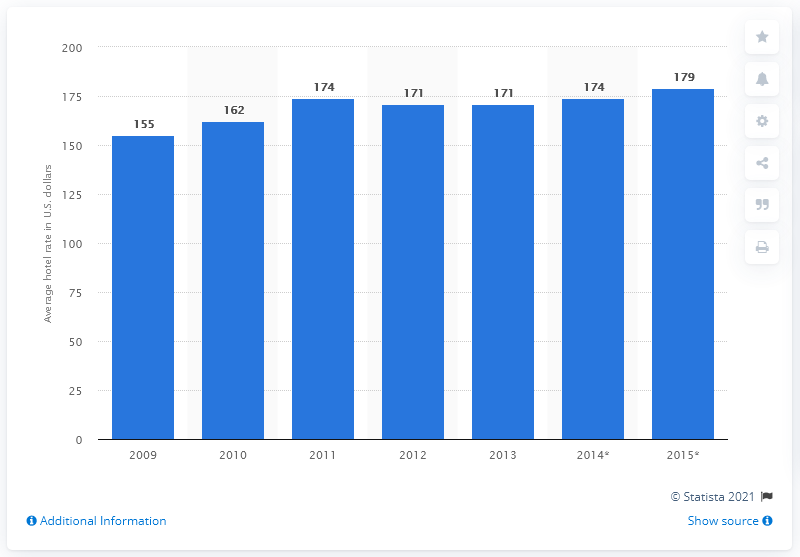

In [3]:
# Select a random row from the DataFrame
random_row = combined_df.sample(n=1).iloc[0]
# Retrieve the image path from the selected row
rand_image_path = random_row['imgPath']
rand_image = Image.open(rand_image_path)
rand_image.show()

Top 3 relevant documents based on text query:
1. Title: 
                        Average global hotel rates from 2009 to 2015 
                    
                            (in U.S. dollars)
                         
 Content:  This statistic shows average global hotel rates from 2009 to 2015. In 2013, the average global hotel rate was 171 U.S. dollars. This figure was forecasted to increase to 174 U.S. dollars in 2014 and again to 179 dollars in 2015.  
 Score: 89.66555


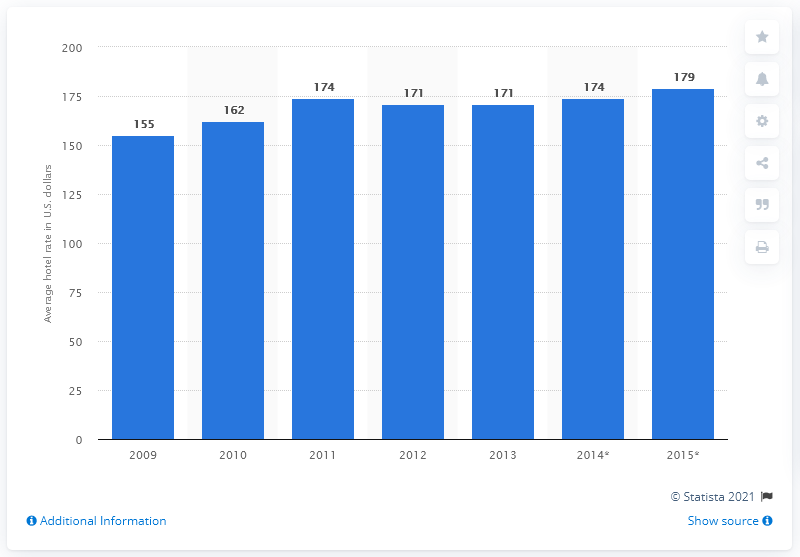

2. Title: 
                        Average travel spend per trip in the United States from 2012 to 2016 (in U.S. dollars)*
                     
 Content:  This statistic shows the average travel spend per trip in the United States from 2012 to 2016. In the 12 months leading up to May 2014, U.S. travelers spent an average of 1,364 U.S. dollars per trip.  
 Score: 87.07007


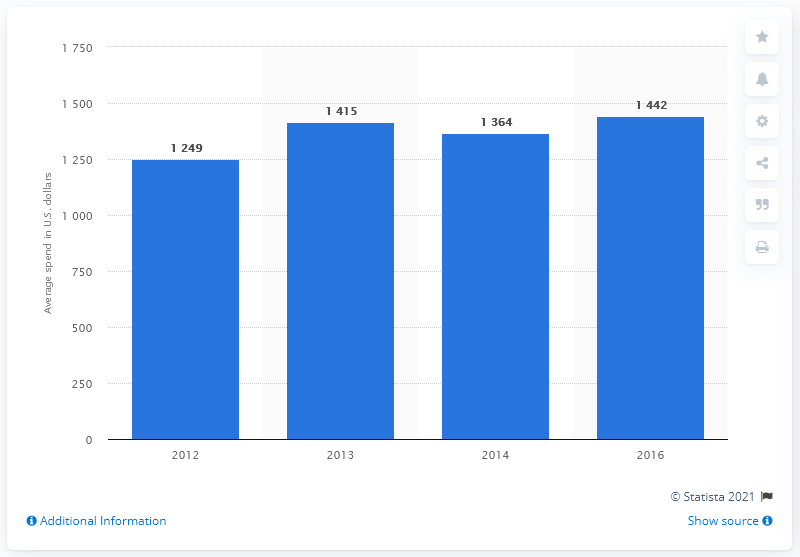

3. Title: 
                        Average room price in hotel transactions in the United Kingdom (UK) from 2009 to 2014 
                    
                            (in GBP)
                         
 Content:  This statistic presents the average price per room in hotel transactions in the United Kingdom (UK) between 2009 and 2014. In 2014 the average price per room in hotel transactions was 169,085 British pounds, which continues the trend of lower prices of the previous year and stands in contrast to the peak of 319,316 British pounds in 2010.  
 Score: 86.386024


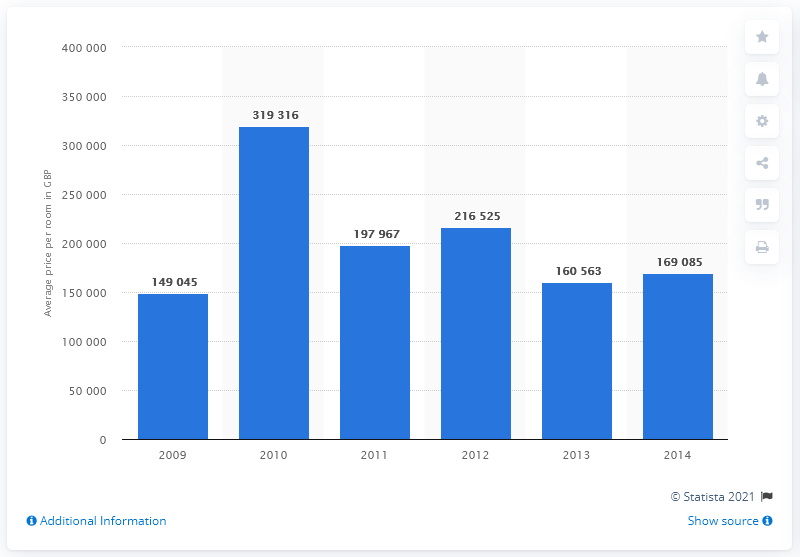

In [4]:
# Text query example and fetching images based on text query
text_query = "What are price of hotel rooms in the United States?"
query_emb = generate_embedding(rand_image,text_query)

# Elasticsearch query to find relevant images
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'imgtext_embedding') * params.logit_scale + 1.0",
            "params": {
                "query_vector": query_emb,
                "logit_scale": logit_scale
            }
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on text query:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()